# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
!pip install --upgrade pip
!pip install torch
#!pip install torchvision
#!pip install -U numpy
#!pip show numpy

Traceback (most recent call last):
  File "/anaconda3/bin/pip", line 8, in <module>
    sys.exit(main())
  File "/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/main.py", line 73, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
  File "/anaconda3/lib/python3.7/site-packages/pip/_internal/commands/__init__.py", line 96, in create_command
    module = importlib.import_module(module_path)
  File "/anaconda3/lib/python3.7/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1006, in _gcd_import
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_f

In [2]:
# can comment out after executing
!unzip processed_celeba_small.zip

unzip:  cannot find or open processed_celeba_small.zip, processed_celeba_small.zip.zip or processed_celeba_small.zip.ZIP.


In [3]:
# necessary imports
import pandas as pd
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image 
import glob
import os

In [4]:
data_dir = 'processed_celeba_small/'
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests


%matplotlib inline

In [5]:
# Parameter settings

train_n = 41
param = 'drop'

# set parameter sets
number_epochs = [1, 10, 50, 100, 500, 1000]
lr_set = [0.0002]
batch_size_set = [32]
conv_dim_set = [64, 128, 256]

# default
batch_size = 32
img_size = 32
n_epochs = 101
conv_dim = 64
lr = 0.0002
beta1=0.2
beta2=0.999
z_size = 100

In [6]:
# Make directories if they do not exist
data_dir = './training_results_pkl2'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
data_dir = './training_results'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
data_dir = './image_sets'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [7]:
print('Number of images used for the Discriminator Training: ', len(glob.glob("processed_celeba_small/celeba/*.jpg")))

Number of images used for the Discriminator Training:  10674


In [8]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    # Tensor transform
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor()
                                    ])
    
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

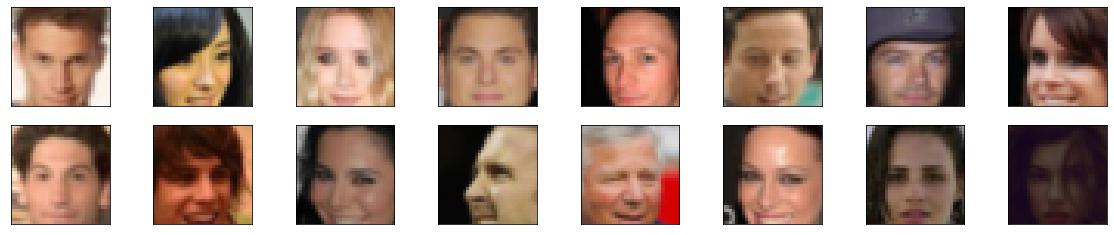

In [10]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=16
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [11]:
fig.savefig('image_sets/orig_examples.png')

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [12]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
     # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x
    

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8667)
Max:  tensor(0.9922)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [14]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [15]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        # 2x2 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        
        # set dropout layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        #out = self.dropout(out)
        out = F.leaky_relu(self.conv2(out), 0.2)
        #out = self.dropout(out)
        out = F.leaky_relu(self.conv3(out), 0.2)
        #out = self.dropout(out)
        out = F.leaky_relu(self.conv4(out), 0.2)
        # flatten
        out = out.view(-1, self.conv_dim*8*2*2)
        #out = self.dropout(out)
        # final output layer
        out = self.fc(out)        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [16]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


In [17]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv3 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        
        # set dropout layer
        self.dropout = nn.Dropout(p=0.5)
        

    def forward(self, x):
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 2, 2) # (batch_size, depth, 2, 2)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        #out = self.dropout(out)
        out = F.relu(self.t_conv2(out))
        #out = self.dropout(out)
        out = F.relu(self.t_conv3(out))
        #out = self.dropout(out)
        # last layer + tanh activation
        out = self.t_conv4(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [18]:
# takes in a module and applies the specified weight initialization
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and classname.find('Linear') != -1:
        m.weight.data.normal_(0, 0.02)
        m.bias.data.fill_(0)
    
    elif hasattr(m, 'weight') and classname.find('Conv') != -1:
        m.weight.data.normal_(0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [20]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [22]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        labels = torch.ones(batch_size)*0.9 # smooth, real labels = 0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models.

In [23]:
# Create optimizers for the discriminator and generator
def optimizer(lr):
    d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
    g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

    return d_optimizer, g_optimizer

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [24]:
# save chosen hyperparameters of the actual training run to an excel file
def save_data(index, losses, batch_size):
    losses = np.array(losses)
    
    # Export Loss as Dataframe
    idx = range(len(losses.T[0]))
    d = {'Discriminator': losses.T[0], 'Generator': losses.T[1]}
    loss_df = pd.DataFrame(data=d, index = idx)
    train_number = train_n + index
    loss_df.to_excel('training_results/train_' + str(train_number) +'_'+ param + ".xlsx")
    
    # Export hyperparameters
    hyper_params = {'batch_size': batch_size,
                'img_size': img_size,
                'deconv-layers': 3,
                'conv-layers': 3,
                'd_conv_dim': d_conv_dim,
                'g_conv_dim': g_conv_dim,
                'z_size': z_size,
                'lr': lr,
                'beta1': beta1,
                'beta2': beta2,
                'dropout': 'no',
                'n_epochs': n_epochs
                }
    hyper_param_df = pd.DataFrame.from_dict(hyper_params, orient='index')
    hyper_param_df.to_excel('training_results/train_' + str(train_number) +'_'+ param + "_hyper_param.xlsx")
    print(hyper_params)

In [25]:
# plot the training losses of Discriminator and Generator for the actual training run
def plot_training_loss(losses):
    print('Plot Loss')
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()
    plt.show()

In [26]:
# helper function for viewing a list of passed in sample images
def view_samples(index, epoch):
    print('View Samples')
    train_number = train_n + index
    # Load samples from generator, taken while training
    with open('training_results_pkl/train_' + str(train_number) +'_'+ param + '_' + str(epoch) + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[-1]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    plt.show()

In [27]:
def train(D, G,  n_epochs, index=0, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    train_number = train_n + index
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # ============================================
            #            TRAIN THE DISCRIMINATOR
            # ============================================

            d_optimizer.zero_grad()

            # 1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()


            # =========================================
            #            TRAIN THE GENERATOR
            # =========================================
            g_optimizer.zero_grad()

            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

        if epoch % 10 == 0:
            # Save training generator samples
            with open('training_results_pkl/train_' + str(train_number) +'_'+ param + '_' + str(epoch) + '_samples.pkl', 'wb') as f:
                pkl.dump(samples, f)
                
            _ = view_samples(index, epoch)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

Epoch [    1/    1] | d_loss: 1.2955 | g_loss: 2.2830
Epoch [    1/    1] | d_loss: 1.1258 | g_loss: 11.2575
Epoch [    1/    1] | d_loss: 1.9004 | g_loss: 7.8252
Epoch [    1/    1] | d_loss: 2.0944 | g_loss: 6.7422
Epoch [    1/    1] | d_loss: 1.4758 | g_loss: 7.5701
Epoch [    1/    1] | d_loss: 0.5969 | g_loss: 1.5199
Epoch [    1/    1] | d_loss: 0.3624 | g_loss: 2.2342
Epoch [    1/    1] | d_loss: 0.4894 | g_loss: 2.6499
Epoch [    1/    1] | d_loss: 0.6484 | g_loss: 2.2066
View Samples


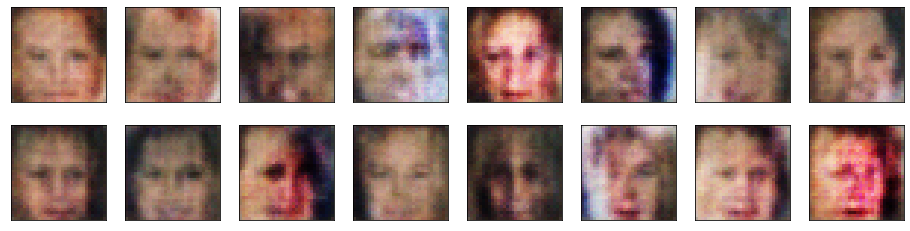

In [28]:
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])
n_epochs=1
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Build Network
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, ke

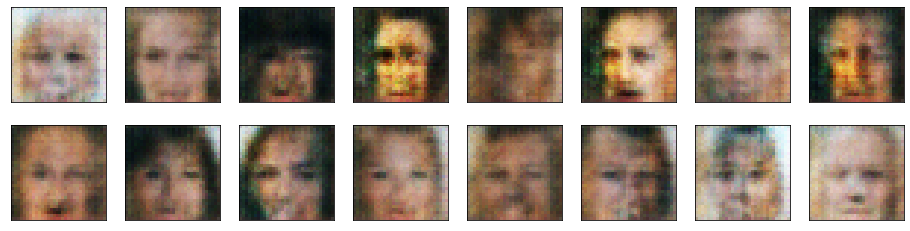

Epoch [    2/  101] | d_loss: 0.5238 | g_loss: 2.4160
Epoch [    2/  101] | d_loss: 0.7542 | g_loss: 2.0317
Epoch [    2/  101] | d_loss: 0.6437 | g_loss: 1.5267
Epoch [    2/  101] | d_loss: 0.8731 | g_loss: 3.9009
Epoch [    2/  101] | d_loss: 0.6192 | g_loss: 1.7928
Epoch [    2/  101] | d_loss: 0.9172 | g_loss: 3.2137
Epoch [    2/  101] | d_loss: 0.7555 | g_loss: 2.4427
Epoch [    2/  101] | d_loss: 0.9912 | g_loss: 2.8768
Epoch [    2/  101] | d_loss: 0.6568 | g_loss: 1.6763
Epoch [    3/  101] | d_loss: 0.6284 | g_loss: 2.1451
Epoch [    3/  101] | d_loss: 1.1604 | g_loss: 0.9214
Epoch [    3/  101] | d_loss: 0.9098 | g_loss: 1.5427
Epoch [    3/  101] | d_loss: 0.8109 | g_loss: 1.3125
Epoch [    3/  101] | d_loss: 1.0621 | g_loss: 1.9384
Epoch [    3/  101] | d_loss: 0.9515 | g_loss: 2.7838
Epoch [    3/  101] | d_loss: 0.5465 | g_loss: 2.4699
Epoch [    3/  101] | d_loss: 0.9451 | g_loss: 1.5286
Epoch [    3/  101] | d_loss: 1.0027 | g_loss: 1.2625
Epoch [    4/  101] | d_loss

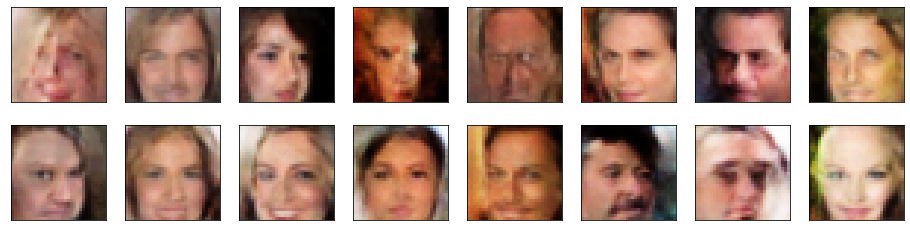

Epoch [   12/  101] | d_loss: 0.9700 | g_loss: 4.1199
Epoch [   12/  101] | d_loss: 0.6472 | g_loss: 1.6945
Epoch [   12/  101] | d_loss: 0.6124 | g_loss: 3.1994
Epoch [   12/  101] | d_loss: 0.8981 | g_loss: 3.6507
Epoch [   12/  101] | d_loss: 0.9938 | g_loss: 3.2850
Epoch [   12/  101] | d_loss: 0.7388 | g_loss: 2.3598
Epoch [   12/  101] | d_loss: 0.9196 | g_loss: 2.9606
Epoch [   12/  101] | d_loss: 0.7515 | g_loss: 1.6778
Epoch [   12/  101] | d_loss: 1.8410 | g_loss: 0.4497
Epoch [   13/  101] | d_loss: 0.6911 | g_loss: 2.9619
Epoch [   13/  101] | d_loss: 0.6934 | g_loss: 2.7672
Epoch [   13/  101] | d_loss: 0.6123 | g_loss: 1.8977
Epoch [   13/  101] | d_loss: 0.4274 | g_loss: 2.4230
Epoch [   13/  101] | d_loss: 0.7725 | g_loss: 1.4325
Epoch [   13/  101] | d_loss: 1.9892 | g_loss: 1.4314
Epoch [   13/  101] | d_loss: 0.9761 | g_loss: 3.6807
Epoch [   13/  101] | d_loss: 0.6940 | g_loss: 2.2972
Epoch [   13/  101] | d_loss: 0.5430 | g_loss: 2.3777
Epoch [   14/  101] | d_loss

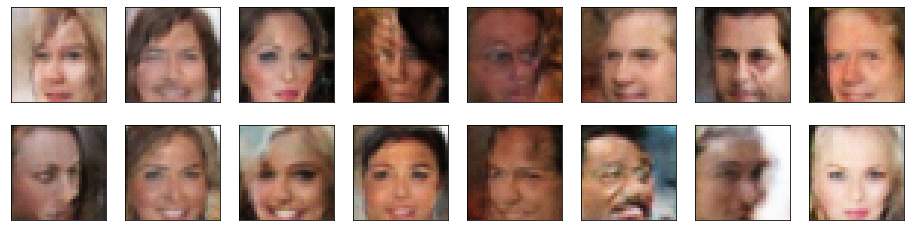

Epoch [   22/  101] | d_loss: 0.5426 | g_loss: 1.8159
Epoch [   22/  101] | d_loss: 0.6228 | g_loss: 3.9580
Epoch [   22/  101] | d_loss: 0.8597 | g_loss: 3.8229
Epoch [   22/  101] | d_loss: 0.3979 | g_loss: 2.2568
Epoch [   22/  101] | d_loss: 0.4951 | g_loss: 3.2299
Epoch [   22/  101] | d_loss: 0.2990 | g_loss: 2.3336
Epoch [   22/  101] | d_loss: 0.4064 | g_loss: 3.9235
Epoch [   22/  101] | d_loss: 0.4479 | g_loss: 3.3684
Epoch [   22/  101] | d_loss: 0.2495 | g_loss: 2.1748
Epoch [   23/  101] | d_loss: 0.5336 | g_loss: 1.7441
Epoch [   23/  101] | d_loss: 0.2086 | g_loss: 3.6518
Epoch [   23/  101] | d_loss: 0.4166 | g_loss: 3.3459
Epoch [   23/  101] | d_loss: 0.3462 | g_loss: 3.6433
Epoch [   23/  101] | d_loss: 0.2190 | g_loss: 3.2458
Epoch [   23/  101] | d_loss: 0.4394 | g_loss: 3.4123
Epoch [   23/  101] | d_loss: 0.1645 | g_loss: 3.0648
Epoch [   23/  101] | d_loss: 0.4542 | g_loss: 1.6982
Epoch [   23/  101] | d_loss: 0.4627 | g_loss: 2.2910
Epoch [   24/  101] | d_loss

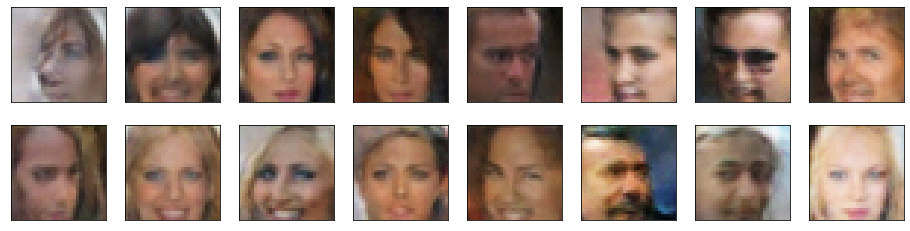

Epoch [   32/  101] | d_loss: 0.2794 | g_loss: 4.2328
Epoch [   32/  101] | d_loss: 0.2134 | g_loss: 3.0363
Epoch [   32/  101] | d_loss: 0.2552 | g_loss: 2.8037
Epoch [   32/  101] | d_loss: 0.0920 | g_loss: 5.0366
Epoch [   32/  101] | d_loss: 0.2789 | g_loss: 4.0891
Epoch [   32/  101] | d_loss: 0.9483 | g_loss: 5.7683
Epoch [   32/  101] | d_loss: 0.3917 | g_loss: 4.4831
Epoch [   32/  101] | d_loss: 0.3729 | g_loss: 3.8877
Epoch [   32/  101] | d_loss: 0.7968 | g_loss: 1.0962
Epoch [   33/  101] | d_loss: 0.2269 | g_loss: 4.4044
Epoch [   33/  101] | d_loss: 0.3783 | g_loss: 2.5306
Epoch [   33/  101] | d_loss: 2.2016 | g_loss: 0.4606
Epoch [   33/  101] | d_loss: 0.2934 | g_loss: 2.4769
Epoch [   33/  101] | d_loss: 0.4635 | g_loss: 1.9619
Epoch [   33/  101] | d_loss: 0.2236 | g_loss: 3.3323
Epoch [   33/  101] | d_loss: 0.6616 | g_loss: 0.9691
Epoch [   33/  101] | d_loss: 0.2755 | g_loss: 2.4483
Epoch [   33/  101] | d_loss: 0.4010 | g_loss: 3.3957
Epoch [   34/  101] | d_loss

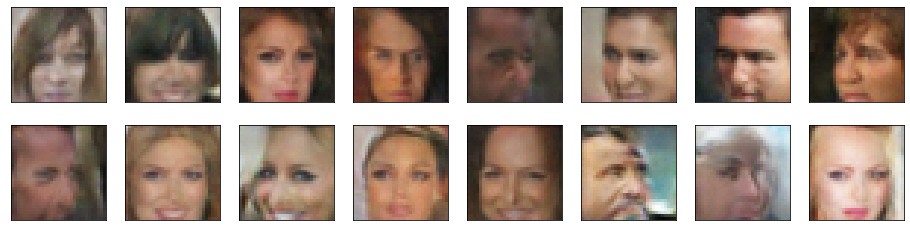

Epoch [   42/  101] | d_loss: 0.0788 | g_loss: 3.9070
Epoch [   42/  101] | d_loss: 0.3907 | g_loss: 3.0424
Epoch [   42/  101] | d_loss: 0.1709 | g_loss: 3.7241
Epoch [   42/  101] | d_loss: 0.5277 | g_loss: 1.6026
Epoch [   42/  101] | d_loss: 0.1400 | g_loss: 4.0269
Epoch [   42/  101] | d_loss: 0.5896 | g_loss: 2.3183
Epoch [   42/  101] | d_loss: 0.2997 | g_loss: 3.9552
Epoch [   42/  101] | d_loss: 0.1733 | g_loss: 4.8693
Epoch [   42/  101] | d_loss: 0.3992 | g_loss: 1.4458
Epoch [   43/  101] | d_loss: 0.0697 | g_loss: 5.7094
Epoch [   43/  101] | d_loss: 0.4203 | g_loss: 3.7334
Epoch [   43/  101] | d_loss: 0.4207 | g_loss: 6.0258
Epoch [   43/  101] | d_loss: 0.0573 | g_loss: 2.6077
Epoch [   43/  101] | d_loss: 0.3675 | g_loss: 5.0719
Epoch [   43/  101] | d_loss: 0.0582 | g_loss: 3.9622
Epoch [   43/  101] | d_loss: 0.3642 | g_loss: 5.8855
Epoch [   43/  101] | d_loss: 0.5065 | g_loss: 3.9554
Epoch [   43/  101] | d_loss: 0.1893 | g_loss: 4.7546
Epoch [   44/  101] | d_loss

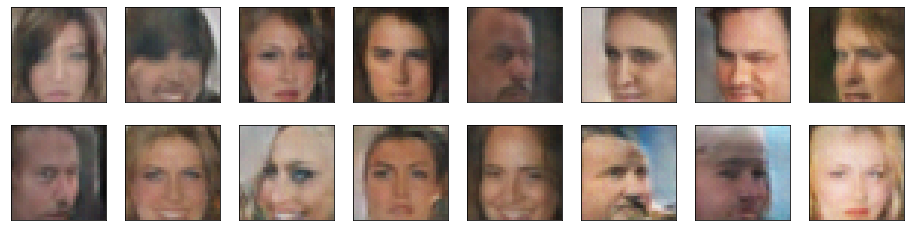

Epoch [   52/  101] | d_loss: 1.0001 | g_loss: 0.9903
Epoch [   52/  101] | d_loss: 1.2840 | g_loss: 7.1092
Epoch [   52/  101] | d_loss: 0.0305 | g_loss: 3.9766
Epoch [   52/  101] | d_loss: 0.2369 | g_loss: 4.5545
Epoch [   52/  101] | d_loss: 0.0896 | g_loss: 4.0043
Epoch [   52/  101] | d_loss: 0.4211 | g_loss: 2.9763
Epoch [   52/  101] | d_loss: 0.0643 | g_loss: 3.6770
Epoch [   52/  101] | d_loss: 0.2348 | g_loss: 3.2969
Epoch [   52/  101] | d_loss: 0.1595 | g_loss: 4.4167
Epoch [   53/  101] | d_loss: 0.1083 | g_loss: 4.2732
Epoch [   53/  101] | d_loss: 0.0268 | g_loss: 3.9909
Epoch [   53/  101] | d_loss: 0.1022 | g_loss: 5.1917
Epoch [   53/  101] | d_loss: 0.6188 | g_loss: 3.1529
Epoch [   53/  101] | d_loss: 0.2077 | g_loss: 4.6116
Epoch [   53/  101] | d_loss: 0.2533 | g_loss: 2.3333
Epoch [   53/  101] | d_loss: 0.1344 | g_loss: 3.1054
Epoch [   53/  101] | d_loss: 0.1921 | g_loss: 4.3368
Epoch [   53/  101] | d_loss: 0.1161 | g_loss: 5.0145
Epoch [   54/  101] | d_loss

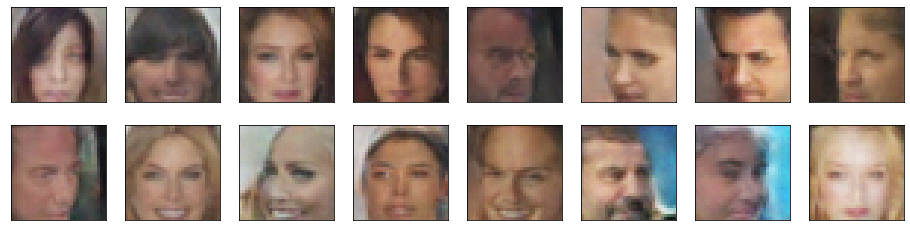

Epoch [   62/  101] | d_loss: 0.2335 | g_loss: 3.6909
Epoch [   62/  101] | d_loss: 0.4194 | g_loss: 5.1356
Epoch [   62/  101] | d_loss: 0.0504 | g_loss: 3.9296
Epoch [   62/  101] | d_loss: 0.1091 | g_loss: 4.3033
Epoch [   62/  101] | d_loss: 0.0869 | g_loss: 5.1482
Epoch [   62/  101] | d_loss: 0.3629 | g_loss: 6.4174
Epoch [   62/  101] | d_loss: 0.1925 | g_loss: 6.6503
Epoch [   62/  101] | d_loss: 0.1988 | g_loss: 3.6850
Epoch [   62/  101] | d_loss: 0.0227 | g_loss: 4.6987
Epoch [   63/  101] | d_loss: 0.0394 | g_loss: 6.5008
Epoch [   63/  101] | d_loss: 0.1153 | g_loss: 6.5464
Epoch [   63/  101] | d_loss: 0.0176 | g_loss: 7.7502
Epoch [   63/  101] | d_loss: 0.0339 | g_loss: 6.0319
Epoch [   63/  101] | d_loss: 0.3704 | g_loss: 4.2853
Epoch [   63/  101] | d_loss: 0.0895 | g_loss: 4.3197
Epoch [   63/  101] | d_loss: 0.0357 | g_loss: 4.9633
Epoch [   63/  101] | d_loss: 0.0660 | g_loss: 4.2358
Epoch [   63/  101] | d_loss: 0.2011 | g_loss: 4.4295
Epoch [   64/  101] | d_loss

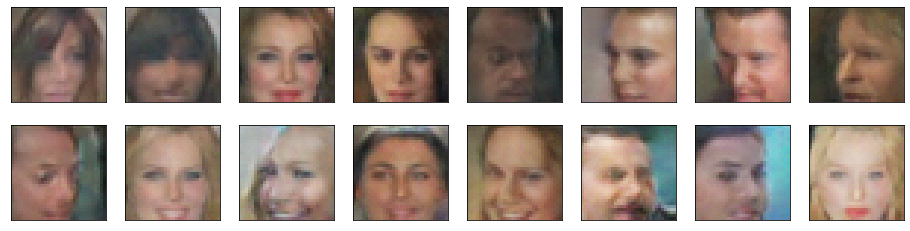

Epoch [   72/  101] | d_loss: 0.0241 | g_loss: 4.3739
Epoch [   72/  101] | d_loss: 0.3871 | g_loss: 6.1418
Epoch [   72/  101] | d_loss: 0.3813 | g_loss: 2.1920
Epoch [   72/  101] | d_loss: 0.0549 | g_loss: 5.4099
Epoch [   72/  101] | d_loss: 0.1542 | g_loss: 4.1264
Epoch [   72/  101] | d_loss: 0.1034 | g_loss: 3.9198
Epoch [   72/  101] | d_loss: 0.0501 | g_loss: 5.5707
Epoch [   72/  101] | d_loss: 0.1948 | g_loss: 5.4382
Epoch [   72/  101] | d_loss: 0.3207 | g_loss: 3.4503
Epoch [   73/  101] | d_loss: 0.0618 | g_loss: 5.3127
Epoch [   73/  101] | d_loss: 0.1363 | g_loss: 6.4081
Epoch [   73/  101] | d_loss: 0.0736 | g_loss: 5.7935
Epoch [   73/  101] | d_loss: 0.0258 | g_loss: 6.4036
Epoch [   73/  101] | d_loss: 0.0105 | g_loss: 6.2202
Epoch [   73/  101] | d_loss: 4.7261 | g_loss: 10.3960
Epoch [   73/  101] | d_loss: 0.1079 | g_loss: 5.5630
Epoch [   73/  101] | d_loss: 0.0497 | g_loss: 5.0691
Epoch [   73/  101] | d_loss: 0.3024 | g_loss: 3.6849
Epoch [   74/  101] | d_los

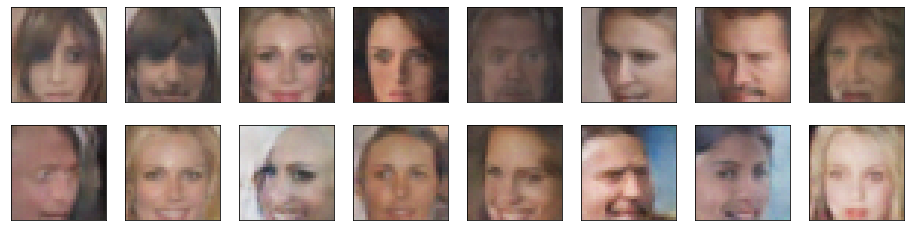

Epoch [   82/  101] | d_loss: 0.0679 | g_loss: 4.9042
Epoch [   82/  101] | d_loss: 0.0250 | g_loss: 5.8878
Epoch [   82/  101] | d_loss: 0.1151 | g_loss: 6.6265
Epoch [   82/  101] | d_loss: 0.0258 | g_loss: 5.7429
Epoch [   82/  101] | d_loss: 0.1112 | g_loss: 5.0796
Epoch [   82/  101] | d_loss: 0.1229 | g_loss: 6.1143
Epoch [   82/  101] | d_loss: 0.0066 | g_loss: 6.9576
Epoch [   82/  101] | d_loss: 0.0422 | g_loss: 5.6928
Epoch [   82/  101] | d_loss: 0.0384 | g_loss: 3.9673
Epoch [   83/  101] | d_loss: 0.0495 | g_loss: 6.2911
Epoch [   83/  101] | d_loss: 0.0148 | g_loss: 6.4233
Epoch [   83/  101] | d_loss: 0.2442 | g_loss: 8.7052
Epoch [   83/  101] | d_loss: 0.1381 | g_loss: 5.1492
Epoch [   83/  101] | d_loss: 0.0363 | g_loss: 5.9229
Epoch [   83/  101] | d_loss: 0.0201 | g_loss: 6.0932
Epoch [   83/  101] | d_loss: 0.0975 | g_loss: 4.8772
Epoch [   83/  101] | d_loss: 0.0258 | g_loss: 6.2649
Epoch [   83/  101] | d_loss: 0.0680 | g_loss: 6.4554
Epoch [   84/  101] | d_loss

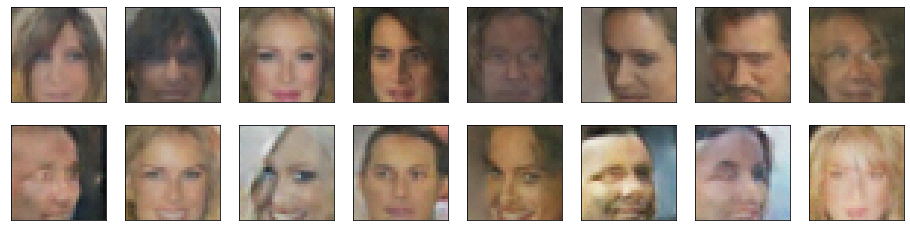

Epoch [   92/  101] | d_loss: 0.0693 | g_loss: 5.2569
Epoch [   92/  101] | d_loss: 0.2304 | g_loss: 5.4624
Epoch [   92/  101] | d_loss: 0.0457 | g_loss: 5.9627
Epoch [   92/  101] | d_loss: 0.0534 | g_loss: 5.9335
Epoch [   92/  101] | d_loss: 0.0172 | g_loss: 4.3063
Epoch [   92/  101] | d_loss: 0.0241 | g_loss: 6.0709
Epoch [   92/  101] | d_loss: 0.5354 | g_loss: 4.3378
Epoch [   92/  101] | d_loss: 0.0526 | g_loss: 5.3754
Epoch [   92/  101] | d_loss: 0.0631 | g_loss: 5.3519
Epoch [   93/  101] | d_loss: 0.0217 | g_loss: 5.6083
Epoch [   93/  101] | d_loss: 0.0308 | g_loss: 5.6860
Epoch [   93/  101] | d_loss: 0.2257 | g_loss: 7.5429
Epoch [   93/  101] | d_loss: 0.0562 | g_loss: 6.3845
Epoch [   93/  101] | d_loss: 0.0596 | g_loss: 7.5026
Epoch [   93/  101] | d_loss: 0.1635 | g_loss: 5.7564
Epoch [   93/  101] | d_loss: 0.1080 | g_loss: 7.0192
Epoch [   93/  101] | d_loss: 2.5159 | g_loss: 1.5512
Epoch [   93/  101] | d_loss: 0.2077 | g_loss: 7.8545
Epoch [   94/  101] | d_loss

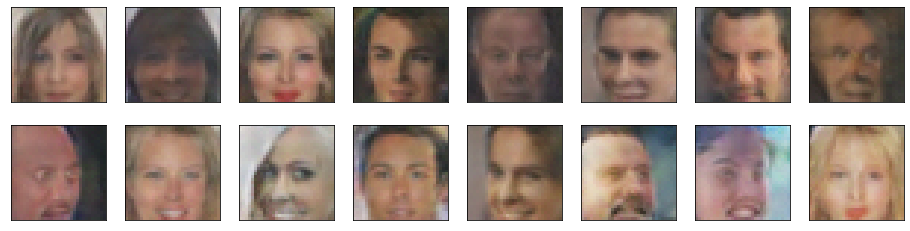

{'batch_size': 32, 'img_size': 32, 'deconv-layers': 3, 'conv-layers': 3, 'd_conv_dim': 64, 'g_conv_dim': 64, 'z_size': 100, 'lr': 0.0002, 'beta1': 0.2, 'beta2': 0.999, 'dropout': 'no', 'n_epochs': 101}
Plot Loss


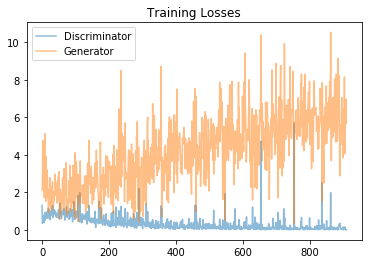

In [29]:
# tune hyperparameters by calling the training function in a loop
n_epochs=101
#for index, n_epochs in enumerate(number_epochs):
#for index, conv_dim in enumerate(conv_dim_set):
#for index, lr in enumerate(lr_set):
for index, batch_size in enumerate(batch_size_set):
    # Set Parameter
    n_epochs = n_epochs
    lr = lr
    batch_size = batch_size
    d_conv_dim = conv_dim
    g_conv_dim = conv_dim
    
    # Get dataloader
    celeba_train_loader = get_dataloader(batch_size, img_size)
    
    # Build network
    print('Build Network')
    D, G = build_network(d_conv_dim, g_conv_dim, z_size)
    
    # Reset optimizer
    d_optimizer, g_optimizer = optimizer(lr)
    
    # Calculate losses
    losses = train(D, G, n_epochs=n_epochs, index=index)
    
    # Save and Plot Data
    save_data(index, losses, batch_size)
    plot_training_loss(losses)
    #_ = view_samples(index, epoch=-1)
    

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

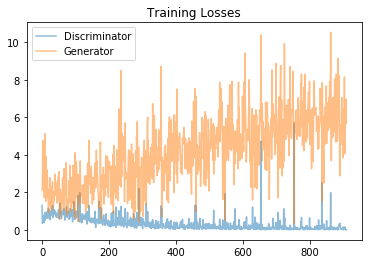

In [30]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [31]:
# helper function for viewing a list of passed in sample images
def view_samples_2(epoch, samples, train_num, param_value):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    fig.suptitle(param_value)
    fig.savefig('image_sets/train_' + str(train_num) + '_' + str(param_value) + '.png')

In [32]:
# helper function for viewing a list of passed in sample images
def view_plots(train_runs, title, param):
    number_of_pots = len(train_runs)
    train_run_list = [m[0] for m in train_runs]
    param_list = [m[1] for m in train_runs]
    epochs_calc = [m[2] for m in train_runs]
    
    ax_set = ('a' + str(m) for m in range(number_of_pots))
    
    fig, ax_set = plt.subplots(figsize=(16,4), nrows=1, ncols=number_of_pots)
    fig.suptitle(title)
    for ii,train_num in enumerate(train_run_list):
        df = pd.read_excel('training_results/train_' + str(train_num) + '_' + str(param_list[ii]) + '.xlsx')  # doctest: +SKIP
        loss_d = df['Discriminator'].values
        loss_g = df['Generator'].values
        ax_set[ii].plot(df.index/epochs_calc[ii], loss_d, label='Discriminator')
        ax_set[ii].plot(df.index/epochs_calc[ii], loss_g, label='Generator')
        ax_set[ii].set_title('Train_' + str(train_num))
        #ax_set[ii].xlabel('n_epochs', fontsize=14)
        #ax_set[iniidex].ylabel('loss', fontsize=14)
        ax_set[ii].legend()
        
    fig.savefig('plots/train_' + str(param) + '.png')

In the following section the parameter tuning which was investigated in separated training runs is appended. 

## Parameter: n_epochs

Parameters          | 1st Train-Run | 2nd Train-Run | 3rd Train-Run | 4th Train-Run | 5th Train-Run | 6th Train-Run |
----------          | ------------- | ------------- | ------------- | ------------- | ------------- | ------------- |
batch_size          |   128         |   128         |   128         |   128         |   128         |   128         |
img_size            |   32          |   32          |   32          |   32          |   32          |   32          |
deconv-layers       |   3           |   3           |   3           |   3           |   3           |   3           |
conv-layers         |   3           |   3           |   3           |   3           |   3           |   3           |
d_conv_dim          |   32          |   32          |   32          |   32          |   32          |   32          |
g_conv_dim          |   32          |   32          |   32          |   32          |   32          |   32          |
z_size              |   100         |   100         |   100         |   100         |   100         |   100         |
lr                  |   0.001       |   0.001       |   0.001       |   0.001       |   0.001       |   0.001       |  
beta1               |   0.5         |   0.5         |   0.5         |   0.5         |   0.5         |   0.5         |
beta2               |   0.999       |   0.999       |   0.999       |   0.999       |   0.999       |   0.999       |
dropout             |   no          |   no          |   no          |   no          |   no          |   no          |
**n_epochs**        |   `1`         |   `10`        |   `50`        |   `100`       |   `500`       |   `1000`      |

In [33]:
# n_epochs = 1, 10, 50, 100, 200, 300, 400, 500
parameter_list_name = [6* 'Train32 best off']
train_num_list = [6* best_off]
param_list = ['num_epochs', 'num_epochs', 'num_epochs', 'num_epochs', 'num_epochs', 'num_epochs', 'num_epochs', 'num_epochs']
epoch_list = [1, 10, 50, 100 , 200, 300, 400, 500]
for epoch, param, param_value_name, train_num in zip(epoch_list, param_list, parameter_list_name, train_num_list):
    """
    # plot pkl file
    with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_' + str(epoch) + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    _ = view_samples_2(-1, samples, train_num, param_value_name)
    """
    # plot png file
    plt.figure(figsize=(40,20))
    img = plt.imread('image_sets/train_' + str(train_num) + '_' + str(param_value_name) + '.png')
    plt.axis('off')
    #plt.title(param_value)
    plt.imshow(img)

NameError: name 'best_off' is not defined

In [ ]:
view_plots([[1, 'num_epochs', 3],
            [2, 'num_epochs', 3],
            [3, 'num_epochs', 3],
            [4, 'num_epochs', 3],
            [5, 'num_epochs', 3],
            [6, 'num_epochs', 3]], 'Number of epochs', 'n_epochs') 

### Result for parameter n_epochs:
Best value setting for the number of epochs extends to the range 50...100. Lower epoch values lead to underfitting, higher epoch values tend to pronounced noisy behavior of the discriminator loss. In both regimes the generated face images are blurred. In the following 100 epochs will be used for further parameter studies.

## Parameter: number of conv-layers and deconv-layers	

Parameters          | 4th Train-Run | 8th Train-Run | 
----------          | ------------- | ------------- |
batch_size          |   128         |   128         |  
img_size            |   32          |   32          | 
**deconv-layers**   |   `3`         |   `4`         |
**conv-layers**     |   `3`         |   `4`         | 
d_conv_dim          |   32          |   32          |
g_conv_dim          |   32          |   32          | 
z_size              |   100         |   100         |  
lr                  |   0.001       |   0.001       |  
beta1               |   0.5         |   0.5         | 
beta2               |   0.999       |   0.999       |
dropout             |   no          |   no          |
n_epochs            |   100         |   100         |

In [ ]:
# conv-layers=deconv-layers=3 ... 4
parameter_list_name = ['conv-layers=deconv-layers=3','conv-layers=deconv-layers=4']
train_num_list = [4, 8]
param_list = ['num_epochs', 'conv_deconv']
for param, param_value_name, train_num in zip(param_list, parameter_list_name, train_num_list):
    """
    # plot pkl file
    with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    _ = view_samples_2(-1, samples, train_num, param_value_name)
    """
    # plot png file
    plt.figure(figsize=(40,20))
    img = plt.imread('image_sets/train_' + str(train_num) + '.png')
    plt.axis('off')
    #plt.title(param_value)
    plt.imshow(img)

In [ ]:
view_plots([[4, 'num_epochs', 3],
            [8, 'conv_deconv', 3]],'Number of conv- and deconv-layers', 'conv_deconv')  

### Result for parameter number of conv-layers and deconv-layers:
There is no clear trend with regard to the number of conv-layers and deconv-layers. Corresponding images for conv-layers=3 and deconv-layers=3 look similar to conv-layers=4 and deconv-layers=4. However, the trend of losses is slightly better for conv-layers=4 and deconv-layers=4, higher (positive) loss for the Generator and slightly lower loss for the Discriminator. In the following conv-layers=4 and deconv-layers=4 will be used for further parameter studies.

## Parameter: batch_size

Parameters          | 14th Train-Run | 15th Train-Run | 16th Train-Run  | 17th Train-Run |
----------          | ------------- | -------------   | -------------   | -------------  |
**batch_size**      |   `64`        |   `128`         |   `256`         |  `512`         |   
img_size            |   32          |   32            |   32            |   32           |
deconv-layers       |   4           |   4             |   4             |   4            |
conv-layers         |   4           |   4             |   4             |   4            |
d_conv_dim          |   32          |   32            |   32            |   32           |   
g_conv_dim          |   32          |   32            |   32            |   32           |
z_size              |   100         |   100           |   100           |   100          |   
lr                  |   0.001       |   0.001         |   0.001         |   0.001        |  
beta1               |   0.5         |   0.5           |   0.5           |   0.5          |
beta2               |   0.999       |   0.999         |   0.999         |   0.999        |
dropout             |   no          |   no            |   no            |   no           |
n_epochs            |   100         |   100           |   100           |   100          |

In [ ]:
# batch_size= 64 , 128, 256, 512
parameter_list_name = ['batch_size=64','batch_size=128', 'batch_size=256', 'batch_size=512']
train_num_list = [14, 15, 16, 17]
param_list = ['batch_size', 'batch_size', 'batch_size', 'batch_size']
for param, param_value_name, train_num in zip(param_list, parameter_list_name, train_num_list):
    """
    # plot pkl file
    with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    _ = view_samples_2(-1, samples, train_num, param_value_name)
    """
    # plot png file
    plt.figure(figsize=(40,20))
    img = plt.imread('image_sets/train_' + str(train_num) + '.png')
    plt.axis('off')
    #plt.title(param_value)
    plt.imshow(img)

In [ ]:
view_plots([[14, 'batch_size', 5],
            [15, 'batch_size', 3],
            [16, 'batch_size', 2],
            [17, 'batch_size', 1]], 'Batch size', 'batch_size') 

#### Result for parameter batch_size:
A larger batch_size has a positive effect on the computational boost. However, if the batch_size is getting too high the feature resolution is getting worse. This can be clearly seen if one compares a batch_size of 512 with a batch_size of 128. For the further study a batch_size of 128 has been chosen.

## Parameter: conv_dim

Parameters          | 8th Train-Run | 11th Train-Run  | 12th Train-Run  | 13th Train-Run |
----------          | ------------- | -------------   | -------------   | -------------  |
batch_size          |   128         |   128           |   128           |  128           |   
img_size            |   32          |   32            |   32            |   32           |
deconv-layers       |   4           |   4             |   4             |   4            |
conv-layers         |   4           |   4             |   4             |   4            |
**d_conv_dim**      |   `32`        |   `64`          |   `128`         |  `256`         |   
**g_conv_dim**      |   `32`        |   `64`          |   `128`         |  `256`         |
z_size              |   100         |   100           |   100           |   100          |   
lr                  |   0.001       |   0.001         |   0.001         |   0.001        |  
beta1               |   0.5         |   0.5           |   0.5           |   0.5          |
beta2               |   0.999       |   0.999         |   0.999         |   0.999        |
dropout             |   no          |   no            |   no            |   no           |
n_epochs            |   100         |   100           |   100           |   100          |

In [ ]:
# conv_dim= 32, 64 , 128, 256
parameter_list_name = ['conv_dim=32', 'conv_dim=64','conv_dim=128', 'conv_dim=256']
train_num_list = [8, 11, 12, 13]
param_list = ['conv_deconv', 'conv_dim', 'conv_dim', 'conv_dim']
for param, param_value_name, train_num in zip(param_list, parameter_list_name, train_num_list):
    """
    # plot pkl file
    with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    _ = view_samples_2(-1, samples, train_num, param_value_name)
    """
    # plot png file
    plt.figure(figsize=(40,20))
    img = plt.imread('image_sets/train_' + str(train_num) + '.png')
    plt.axis('off')
    #plt.title(param_value)
    plt.imshow(img)

In [ ]:
view_plots([[8, 'conv_deconv', 3],
            [11, 'conv_dim', 3],
            [12, 'conv_dim', 3],
            [13, 'conv_dim', 3]], 'Size of conv_dim', 'conv_dim') 

#### Result for parameter conv_dim:
With a higher conv_dim for the Generator and the Discriminator the resolution of feature details is getting higher. For example, eyes are better resolved with a conv_dim=256 than with a conv_dim=32. However, even a conv_dim of 64 leads to convincing results.

### Parameter: lr

Parameters          | 21th Train-Run | 14th Train-Run  | 22th Train-Run |
----------          | ------------- | -------------   | -------------   |
batch_size          |   128         |   128           |   128           |   
img_size            |   32          |   32            |   32            |   
deconv-layers       |   4           |   4             |   4             |   
conv-layers         |   4           |   4             |   4             |   
d_conv_dim          |   64          |   64            |   64            |    
g_conv_dim          |   64          |   64            |   64            |   
z_size              |   100         |   100           |   100           |    
**lr**              |   `0.01`      |   `0.001`       |   `0.0001`      |   
beta1               |   0.5         |   0.5           |   0.5           |   
beta2               |   0.999       |   0.999         |   0.999         |   
dropout             |   no          |   no            |   no            |   
n_epochs            |   100         |   100           |   100           | 

In [ ]:
# lr= 0.01, 0.001, 0.0001
parameter_list_name = ['lr=0.01', 'lr=0.001','lr=0.0001']
train_num_list = [21, 14, 22]
param_list = ['lr', 'batch_size', 'lr', 'conv_dim']
for param, param_value_name, train_num in zip(param_list, parameter_list_name, train_num_list):
    """
    # plot pkl file
    with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    _ = view_samples_2(-1, samples, train_num, param_value_name)
    """
    # plot png file
    plt.figure(figsize=(40,20))
    img = plt.imread('image_sets/train_' + str(train_num) + '.png')
    plt.axis('off')
    #plt.title(param_value)
    plt.imshow(img)

In [ ]:
view_plots([[21, 'lr', 3],
            [14, 'batch_size', 3],
            [22, 'lr', 3]], 'Learning rate', 'lr')

#### Result for parameter lr:
Learning rates in the range between 0.01 and 0.0001 were tested. In all three cases the GAN is able to learn and generated fake images of faces are successfully constructed. However,  a learning rate of lr=0.001 or lr=0.0001 lead to a slightly better feature resolution than lr = 0.01.

### Final hyperparameter setting
The following table shows the best-of setting of the investigated parameter tuning.

Parameters          | 14th Train-Run|
----------          | ------------- |
batch_size          |   32          |  
img_size            |   32          |  
deconv-layers       |   4           |  
conv-layers         |   4           |  
d_conv_dim          |   64          |    
g_conv_dim          |   64          |  
z_size              |   100         |  
lr                  |   0.0002      |   
beta1               |   0.2         |   
beta2               |   0.999       |     
dropout             |   yes         |   
n_epochs            |   100         | 

### Final fake image output

In [ ]:
# final result
parameter_list_name = ['Final result']
train_num_list = [22]
param_list = ['lr']
for param, param_value_name, train_num in zip(param_list, parameter_list_name, train_num_list):
    """
    # plot pkl file
    with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    _ = view_samples_2(-1, samples, train_num, param_value_name)
    """
    # plot png file
    plt.figure(figsize=(40,20))
    img = plt.imread('image_sets/train_' + str(train_num) + '.png')
    plt.axis('off')
    #plt.title(param_value)
    plt.imshow(img)

### Corresponding loss for the final setting

In [ ]:
# loss for reasonable setting
train_num = 22
param = 'lr'
fig, ax = plt.subplots()
df = pd.read_excel('training_results/train_' + str(train_num) + '_' + str(param) + '.xlsx')  # doctest: +SKIP
loss_d = df['Discriminator'].values
loss_g = df['Generator'].values
plt.plot(df.index/3, loss_d, label='Discriminator')
plt.plot(df.index/3,loss_g, label='Generator')
plt.title("Train_22")
plt.legend()
fig.savefig('plots/train_22_single.png')

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Reasons for the chosen final hyperparameter setting:
A whole bunch of parameters setting were tested in sequences (see evaluation above). 

#### n_epochs:
n_epochs was varied between 1 and 1000. Its best value setting extends to the range 50...100. Lower epoch values lead to underfitting, higher epoch values tend to pronounced noisy behavior of the discriminator loss. For both extreme regimes the generated face images are blurred. Therefore n_epochs was set to 100.

#### number of conv-layers and deconv-layers:
Two models were constructed: one with 3 and another one with 4 conv and deconv layers for the discriminator and generator, respectively. Corresponding images for conv-layers=deconv-layers=3 look similar to conv-layers=deconv-layers=4. Hence, a clear trend is hard to distinguish in these examples. However, the trend of losses is slightly better for conv-layers=deconv-layers=4 than for conv-layers=deconv-layers=3, i.e. the loss for the Generator is higher and the loss for the Discriminator is slightly lower. Therefore conv-layers=4 and deconv-layers=4 have been used for further parameter studies.

#### batch_size:
The value range for the batch_size was chosen between 16 and 512. A larger batch_size has a positive effect on the computational boost. However, if the batch_size is getting too high the feature resolution is getting worse (more blurred). This can be clearly seen if one compares a batch_size of 512 with a batch_size of 128. If the batch size is too small then the gradients will become more unstable and would need to reduce the learning rate. So batch size and learning rate are linked. Also if one use a batch size too big then the gradients will become less noisy but it will take longer to converge. Therefore a batch_size of 128 has been chosen. Up to a batch_size of 512 no out-of-memory errors were observed (getting critical for higher batch_sizes).

##### conv_dim:
The conv_dim value was investigated in the range between 32 and 256. With a higher conv_dim for the Generator and the Discriminator the resolution of feature details is getting higher. For example, eyes are better resolved with a conv_dim=256 than with a conv_dim=32. However, even a conv_dim of 64 leads to convincing results.

#### lr:
As learning rates 0.01, 0.01 and 0.0001 were tested. In all three cases the GAN is able to learn and generated fake images of faces successfully. However, lr=0.001 or lr=0.0001 lead to a slightly better feature resolution than lr = 0.01.

### Further improvements:
- To overcome the issue of a biased dataset (celebrity faces that are mostly white): one could add more images of non-white celebrity faces to get a more balanced dataset in the end.
    
- The model size is limited by the number of conv-layers and deconv-layers which was set to 4 in maximum. Higher values were not tested so far. Increasing the model size could especially enhance the feature extraction of the Discriminator. The adversarial Generator is then forced to produce images with better feature resolution.

- A further increase of the conv_dim could lead to better results. However, this would significantly increase the training time.

- The dataset images are 64x64x3 NumPy images. In the get_dataloader function I resized the images down to 32x32x3. This is the image size for the Discriminator input and the size of the Generator output. This resolution of the generated images is noisy. If one would keep width=64 and height=64 the images could resemble more the original ones. However, this would also increase the training duration.

- Regarding the optimizer strategy: For the Discriminator as well as for the Generator the same type of optimizer (Adam) was chosen with a learning rate down to 0.0001. A combination of different optimizer like SGD for the Discriminator and Adam for the Generator as proposed by [Soumith](https://github.com/soumith/ganhacks) has not been tested yet.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.